In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from module.base.network import Network
from module.simulation.masterequation import MasterEquation
import module.components.CONST as CONST
from module.components.discrete_gaussian1D import DiscreteGaussian1D
from module.simulation.meanfield import MeanField

from module.simulation.set_meanfield2 import SetMeanField2

In [3]:
input_voltage = -0.2
gate_voltage = -0.02

In [4]:
net = Network(1, 1, 1, [[0,0,0], [0,0,0]])
net.set_voltage_config([input_voltage, 0], gate_voltage)
me = MasterEquation(input_voltage, gate_voltage)
gaussian = DiscreteGaussian1D()

In [5]:
me_probs = me.solve(verbose = True)
me_mean = np.sum(me.phase_space * me_probs)
me_var = np.sum(me.phase_space ** 2 * me_probs) - me_mean**2
print("me mean:", me_mean)
print("me var:", me_var)

convergence: 2.2885351391721542e-07
me mean: -2.166491494671686
me var: 1.9653458880298595


In [6]:
gauss_probs = gaussian.calc_prob(me_mean, me_var)
gauss_mean = np.sum(gaussian.phase_space * gauss_probs)
gauss_var = np.sum(gaussian.phase_space ** 2 * gauss_probs) - gauss_mean**2
print("gauss mean:", gauss_mean)
print("gauss var:", gauss_var)

gauss mean: -2.1664914946716864
gauss var: 1.9643862466234898


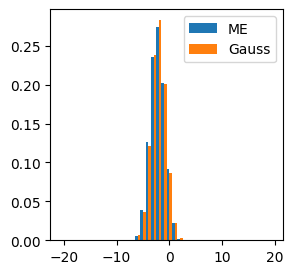

In [8]:
plt.figure(figsize = (3, 3))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [9]:
def get_rate_to_island(phase_space):
    """
    Calculates the total rate towards the island for given phase space snippet.
    """
    space = np.expand_dims(phase_space, axis = -1)
    return net.calc_rate_from_electrode(space, 0) + net.calc_rate_from_electrode(space, 1)
    
def get_rate_from_island(phase_space):
    """
    Calculates the total rate towards the electrodes for given occupation number.
    """
    space = np.expand_dims(phase_space, axis = -1)
    return net.calc_rate_to_electrode(space, 0) + net.calc_rate_to_electrode(space, 1)

def I(phase_space):
    return get_rate_to_island(phase_space) - get_rate_from_island(phase_space)

def I_dag(phase_space):
    return get_rate_to_island(phase_space) + get_rate_from_island(phase_space)

def dN2(phase_space):
    return 2 * phase_space * I(phase_space) + I_dag(phase_space)

In [10]:
me_dN = np.sum(I(me.phase_space) * me_probs)
me_dN2 = np.sum(dN2(me.phase_space) * me_probs)
print("me dN:", me_dN)
print("me dN2:", me_dN2)

me dN: -1.9075150394787244e-06
me dN2: 8.257747840190177e-06


In [11]:
gauss_dN = np.sum(I(gaussian.phase_space) * gauss_probs)
gauss_dN2 = np.sum(dN2(gaussian.phase_space) * gauss_probs)
print("gauss dN:", gauss_dN)
print("gauss dN2:", gauss_dN2)

gauss dN: -0.0001462502095206375
gauss dN2: 0.10286869498052198


#### Simulation
---

In [12]:
gauss_mean = me_mean - 4.8
gauss_var = me_var / 4

dt = 0.01

gauss_probs = gaussian.calc_prob(gauss_mean, gauss_var)

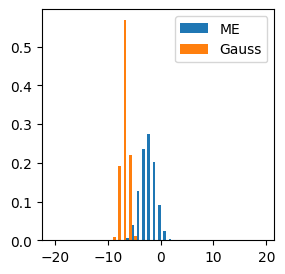

In [13]:
plt.figure(figsize = (3, 3))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [18]:
for i in range(15):
    gauss_probs = gaussian.calc_prob(gauss_mean, gauss_var)
    gauss_dN = np.sum(I(gaussian.phase_space) * gauss_probs)
    gauss_dN2 = np.sum(dN2(gaussian.phase_space) * gauss_probs)
    gauss_dvar = gauss_dN2 - 2 * gauss_mean * gauss_dN

    gauss_mean += dt * gauss_dN
    gauss_var += dt * gauss_dvar

    print("convergence:", max(np.abs(gauss_dN), np.abs(gauss_dvar)))

convergence: 0.04336541996617416
convergence: 0.03848633114312672
convergence: 0.034156194976552756
convergence: 0.03031324782619005
convergence: 0.026902675241712304
convergence: 0.023875830080476224
convergence: 0.021189538600184576
convergence: 0.018805484627358204
convergence: 0.016689663016533185
convergence: 0.014811894603653286
convergence: 0.013145395734325271
convergence: 0.011666396226451159
convergence: 0.010353800317296713
convergence: 0.00918888575878185
convergence: 0.00815503676847551


In [19]:
gauss_probs = gaussian.calc_prob(me_mean, me_var)
gauss_mean = np.sum(gaussian.phase_space * gauss_probs)
gauss_var = np.sum(gaussian.phase_space ** 2 * gauss_probs) - gauss_mean**2
print("gauss mean:", gauss_mean)
print("gauss var:", gauss_var)

gauss mean: -2.1664914946716864
gauss var: 1.9643862466234898


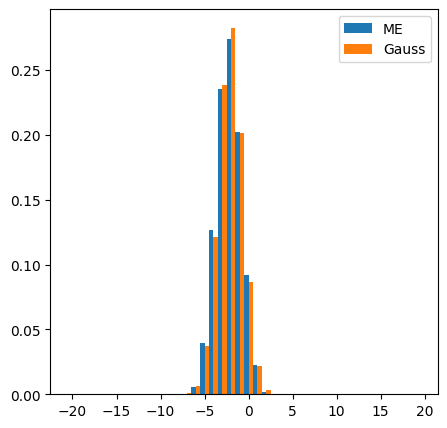

In [20]:
plt.figure(figsize = (5, 5))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [21]:
print("comparison of means and variances of Master Equation and Mean Field:")
print("d_mean:", gauss_mean - me_mean)
print("d_var:", gauss_var - me_var)

comparison of means and variances of Master Equation and Mean Field:
d_mean: -4.440892098500626e-16
d_var: -0.0009596414063697267


In [22]:
print("me current:", me.expected_current(me_probs))
mf = MeanField(net)
n = mf.numeric_integration_solve(verbose = True)
-(mf.calc_expected_electrode_rates(n, 1)) * CONST.electron_charge

me current: -3.5485858036960103
convergence: 0.0


-3.5483307619383253

#### SetMeanField2 class
---

In [30]:
mf2 = SetMeanField2(input_voltage, gate_voltage)

In [31]:
mean, var = mf2.solve(verbose = True)
print("mean:", mean)
print("var:", var)

convergence: 2.6201905090061928e-08
mean: -2.1665029764906794
var: 1.9699409875511895


In [32]:
mf2.calc_expected_output_current(mean, var)

-3.54919046249033